## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
PATIENCE = [10, 25]

In [7]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for pat in PATIENCE:
    earlystop = EarlyStopping(monitor="valid_acc", 
                          patience=pat, 
                          verbose=1
                          )
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with patience = %.6f" % (pat))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-pat-%s" % str(pat)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0723 13:17:06.080010 139738694903680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 13:17:06.083190 139738694903680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 13:17:06.127914 139738694903680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 13:17:06.129667 139738694903680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W072

Experiment with patience = 10.000000


W0723 13:17:06.616041 139738694903680 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 13:17:06.737227 139738694903680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `valid_acc` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 9s 184us/step - loss: 1.7512 - acc: 0.3894 - val_loss: 1.7985 - val_acc: 0.3835
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6264 - acc: 0.4309 - val_loss: 1.6868 - val_acc: 0.4113
Epoch 4/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.5535 - acc: 0.4573 - val_loss: 1.6337 - val_acc: 0.4282
Epoch 5/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.4985 - acc: 0.4761 - val_loss: 1.5809 - val_acc: 0.4415
Epoch 6/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.4525 - acc: 0.4940 - val_loss: 1.5657 - val_acc: 0.4498
Epoch 7/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4110 - acc: 0.5065 - val_loss: 1.5505 - val_acc: 0.4534
Epoch 8/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3761 - acc: 0.5206 - val_loss: 1.5224 - val_acc: 0.4655
Epoch 9/50
50000/50000 [=====================

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `valid_acc` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 9s 185us/step - loss: 1.7619 - acc: 0.3884 - val_loss: 1.8535 - val_acc: 0.3692
Epoch 3/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6357 - acc: 0.4292 - val_loss: 1.7446 - val_acc: 0.4012
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5618 - acc: 0.4547 - val_loss: 1.6563 - val_acc: 0.4204
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.5017 - acc: 0.4756 - val_loss: 1.5934 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4560 - acc: 0.4905 - val_loss: 1.5779 - val_acc: 0.4443
Epoch 7/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.4169 - acc: 0.5061 - val_loss: 1.5598 - val_acc: 0.4480
Epoch 8/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.3789 - acc: 0.5205 - val_loss: 1.5356 - val_acc: 0.4595
Epoch 9/50
50000/50000 [=====================

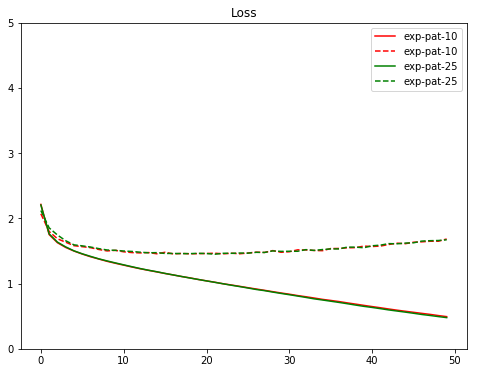

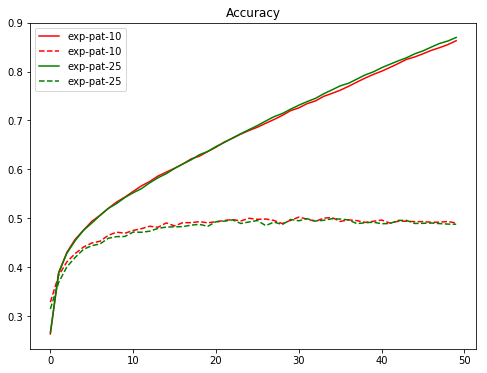

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()